## Attribute: Daily Water Discharge (cubic feet/sec (mean))
####  Dataset duration 13 year 
####  No Outliers removed

## Models: GRU, BiLSTM, LSTM
#### Early Stopping Callbacks removed (50 epoch is used for all for model comparison)
#### Prediction = Red, Real data = Blue 

## MAPE, r2 score and train/test plot added

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

import plotly.graph_objects as go
import plotly.express as px

2023-04-04 14:45:11.570667: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.random.set_seed(1234)

In [3]:
water_data = pd.read_csv('13_year_discharge.csv')
water_data

Date       WD value
0       2/1/10  25900.0     A
1       2/2/10  21000.0     A
2       2/3/10  19800.0     A
3       2/4/10  19800.0     A
4       2/5/10  20200.0     A
...        ...      ...   ...
4712  12/27/22   8760.0     P
4713  12/28/22  10600.0     P
4714  12/29/22   9510.0     P
4715  12/30/22   9940.0     P
4716  12/31/22   9070.0     P

[4717 rows x 3 columns]

In [4]:
water_data['timestamp'] = pd.to_datetime(water_data['Date'])
water_data['water_discharge'] = water_data['WD']
water_data['data_qualification_code'] = water_data['value']

In [5]:
water_data

Date       WD value  timestamp  water_discharge  \
0       2/1/10  25900.0     A 2010-02-01          25900.0   
1       2/2/10  21000.0     A 2010-02-02          21000.0   
2       2/3/10  19800.0     A 2010-02-03          19800.0   
3       2/4/10  19800.0     A 2010-02-04          19800.0   
4       2/5/10  20200.0     A 2010-02-05          20200.0   
...        ...      ...   ...        ...              ...   
4712  12/27/22   8760.0     P 2022-12-27           8760.0   
4713  12/28/22  10600.0     P 2022-12-28          10600.0   
4714  12/29/22   9510.0     P 2022-12-29           9510.0   
4715  12/30/22   9940.0     P 2022-12-30           9940.0   
4716  12/31/22   9070.0     P 2022-12-31           9070.0   

     data_qualification_code  
0                          A  
1                          A  
2                          A  
3                          A  
4                          A  
...                      ...  
4712                       P  
4713                       P  
4714                       P  
4715                       P  
4716                       P  

[4717 rows x 6 columns]

In [6]:
# drop unnecessary colums
water_data =water_data.drop(['Date','WD','value','data_qualification_code'], axis=1)
water_data

timestamp  water_discharge
0    2010-02-01          25900.0
1    2010-02-02          21000.0
2    2010-02-03          19800.0
3    2010-02-04          19800.0
4    2010-02-05          20200.0
...         ...              ...
4712 2022-12-27           8760.0
4713 2022-12-28          10600.0
4714 2022-12-29           9510.0
4715 2022-12-30           9940.0
4716 2022-12-31           9070.0

[4717 rows x 2 columns]

In [7]:
print('Total data point:')
print(len(water_data))
print('Total num of missing values:') 
print(water_data.water_discharge.isna().sum())
print('')


# Locate the missing value
water_data_missing_date = water_data.loc[water_data.water_discharge.isna() == True]
print('The date of missing value:')
print(water_data_missing_date.loc[:,['timestamp']])

i = water_data[water_data.water_discharge.isna() == True].index

Total data point:
4717
Total num of missing values:
5

The date of missing value:
      timestamp
2619 2017-04-04
2676 2017-05-31
2677 2017-06-01
2678 2017-06-02
2679 2017-06-03


In [8]:
# locating the index of the missing values
i = water_data[water_data.water_discharge.isna() == True].index
print(i)

Int64Index([2619, 2676, 2677, 2678, 2679], dtype='int64')


In [9]:
print(water_data.timestamp[i], water_data.water_discharge[i])

2619   2017-04-04
2676   2017-05-31
2677   2017-06-01
2678   2017-06-02
2679   2017-06-03
Name: timestamp, dtype: datetime64[ns] 2619   NaN
2676   NaN
2677   NaN
2678   NaN
2679   NaN
Name: water_discharge, dtype: float64


In [10]:
# replacing missing values in water_discharge column
# with median of that column
water_data['water_discharge'] = water_data['water_discharge'].fillna(water_data['water_discharge'].mean())
print(water_data.timestamp[i], water_data.water_discharge[i])

2619   2017-04-04
2676   2017-05-31
2677   2017-06-01
2678   2017-06-02
2679   2017-06-03
Name: timestamp, dtype: datetime64[ns] 2619    17143.119694
2676    17143.119694
2677    17143.119694
2678    17143.119694
2679    17143.119694
Name: water_discharge, dtype: float64


In [11]:
fig = px.line(water_data.reset_index(), x = 'timestamp', y = 'water_discharge')
fig.update_xaxes(rangeslider_visible = True)
fig.show()

In [12]:
# Set the DATE column as the index.
new_water_data = water_data.set_index('timestamp')
new_water_data.head()

water_discharge
timestamp                  
2010-02-01          25900.0
2010-02-02          21000.0
2010-02-03          19800.0
2010-02-04          19800.0
2010-02-05          20200.0

In [13]:
new_water_data.index

DatetimeIndex(['2010-02-01', '2010-02-02', '2010-02-03', '2010-02-04',
               '2010-02-05', '2010-02-06', '2010-02-07', '2010-02-08',
               '2010-02-09', '2010-02-10',
               ...
               '2022-12-22', '2022-12-23', '2022-12-24', '2022-12-25',
               '2022-12-26', '2022-12-27', '2022-12-28', '2022-12-29',
               '2022-12-30', '2022-12-31'],
              dtype='datetime64[ns]', name='timestamp', length=4717, freq=None)

In [14]:
new_water_data

water_discharge
timestamp                  
2010-02-01          25900.0
2010-02-02          21000.0
2010-02-03          19800.0
2010-02-04          19800.0
2010-02-05          20200.0
...                     ...
2022-12-27           8760.0
2022-12-28          10600.0
2022-12-29           9510.0
2022-12-30           9940.0
2022-12-31           9070.0

[4717 rows x 1 columns]

In [15]:
# finding duplicate
# new_water_data[new_water_data.index.duplicated()]
new_water_data.index.duplicated()

array([False, False, False, ..., False, False, False])

In [16]:
# Drop rows with duplicate index values
final_water_data = new_water_data.loc[~new_water_data.index.duplicated(), :]
final_water_data

water_discharge
timestamp                  
2010-02-01          25900.0
2010-02-02          21000.0
2010-02-03          19800.0
2010-02-04          19800.0
2010-02-05          20200.0
...                     ...
2022-12-27           8760.0
2022-12-28          10600.0
2022-12-29           9510.0
2022-12-30           9940.0
2022-12-31           9070.0

[4717 rows x 1 columns]

In [17]:
# Missing time series row
dt = pd.Series(data = pd.date_range(start=final_water_data.index.min(), end=final_water_data.index.max(), freq = 'D'))
idx = pd. DatetimeIndex(dt)
final_water_data2 = final_water_data.reindex(idx)
final_water_data2

water_discharge
2010-02-01          25900.0
2010-02-02          21000.0
2010-02-03          19800.0
2010-02-04          19800.0
2010-02-05          20200.0
...                     ...
2022-12-27           8760.0
2022-12-28          10600.0
2022-12-29           9510.0
2022-12-30           9940.0
2022-12-31           9070.0

[4717 rows x 1 columns]

In [18]:
df = final_water_data2
df.head()

water_discharge
2010-02-01          25900.0
2010-02-02          21000.0
2010-02-03          19800.0
2010-02-04          19800.0
2010-02-05          20200.0

In [19]:
#Verify that there are no empty cells in any column. The output should be all zeroes.
import numpy as np
df.isin([np.nan, np.inf, -np.inf]).sum()

water_discharge    0
dtype: int64

In [20]:
print('Total data point:')
print(len(df))
print('Total num of missing values:') 
print(df.water_discharge.isna().sum())
print('')


# Locate the missing value
# df_missing_date = df.loc[df.water_discharge.isna() == True]
# print('The date of missing value:')
# print(df_missing_date.loc[:,['']])

Total data point:
4717
Total num of missing values:
0



<Axes: >

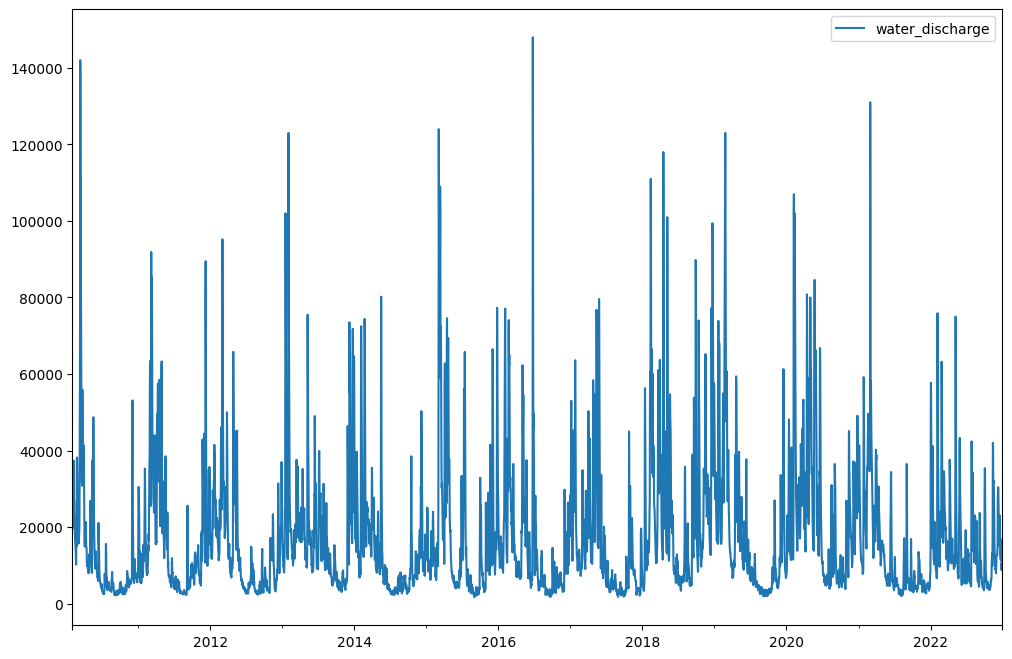

In [21]:
# Plot out the time series
df.plot(figsize=(12,8))

In [22]:
data_count = len(final_water_data2)
print(data_count)


4717


In [23]:
train_size = int(0.8*data_count)
print(train_size)
test_size = data_count-train_size
print(test_size)

3773
944


In [24]:
training_set = df.iloc[:train_size, 0:1].values
training_set

array([[25900.],
       [21000.],
       [19800.],
       ...,
       [66200.],
       [60600.],
       [52900.]])

In [25]:
len(training_set)

3773

In [26]:
testing_set = df.iloc[train_size:, 0:1].values
testing_set.shape

(944, 1)

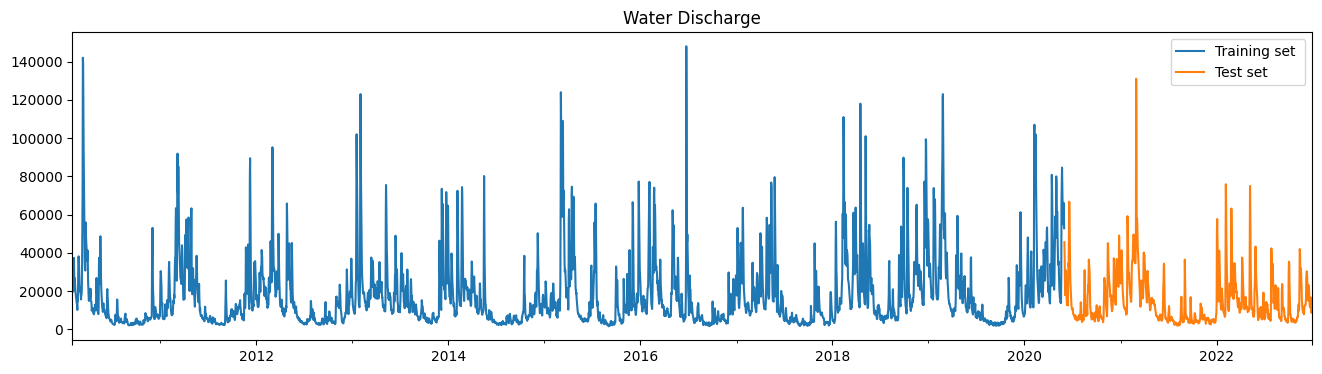

In [27]:
df['water_discharge'][:train_size].plot(figsize=(16,4),legend=True)
df['water_discharge'][train_size:].plot(figsize=(16,4),legend=True)
plt.legend(['Training set ','Test set'])
plt.title('Water Discharge')
plt.show()

In [28]:
# Feature scaling to optimize the training set
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [29]:
# Create a data structure with 1 timesteps and 1 output
# Format it into a three-dimensional array for use in our LSTM model
X_train = []
y_train = []
for i in range(1, train_size):
    X_train.append(training_set_scaled[i-1:i, 0]) # Appending previous 1 data.
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping (LSMT Model needs to be 3- dimensional) following format (values, time-steps, 1 dimensional output).
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(3772, 1, 1)

In [30]:
import keras
def fit_model(model):
    
#-----Early stop implementation-----  
#     early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
#                                                patience = 10)
#     history = model.fit(X_train, y_train, epochs = 50,  
#                         validation_split = 0.2,
#                         batch_size = 16, shuffle = False, 
#                         callbacks = [early_stop])
    
# ------ without Early stop ----
    history = model.fit(X_train, y_train, epochs = 50,  
                        validation_split = 0.2,
                        batch_size = 16, shuffle = False 
                        )    
    return history


In [31]:
# Create GRU model
from keras import optimizers
def create_gru(units):
    model = Sequential()
    # Input layer
    model.add(GRU (units = units, return_sequences = True, 
    input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(GRU(units = units)) 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 

    #Compile model
    model.compile(optimizer='adam' ,loss='mse')
    return model
model_gru = create_gru(64)

2023-04-04 14:46:33.977482: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [32]:
history_gru = fit_model(model_gru)

Epoch 1/50
189/189 [==============================] - 3s 4ms/step - loss: 0.0073 - val_loss: 0.0031
Epoch 2/50
189/189 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 3/50
189/189 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0033
Epoch 4/50
189/189 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0033
Epoch 5/50
189/189 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0034
Epoch 6/50
189/189 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0034
Epoch 7/50
189/189 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0033
Epoch 8/50
189/189 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0032
Epoch 9/50
189/189 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0034
Epoch 10/50
189/189 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0033

In [33]:
# Create BiLSTM model
def create_bilstm(units):
    model = Sequential()
    # Input layer
    model.add(Bidirectional(
              LSTM(units = units, return_sequences=True), 
              input_shape=(X_train.shape[1], X_train.shape[2])))
    # Hidden layer
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(1))
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model
model_bilstm = create_bilstm(64)

In [34]:
history_bilstm = fit_model(model_bilstm)

Epoch 1/50
189/189 [==============================] - 4s 6ms/step - loss: 0.0080 - val_loss: 0.0031
Epoch 2/50
189/189 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 0.0031
Epoch 3/50
189/189 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 0.0031
Epoch 4/50
189/189 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0031
Epoch 5/50
189/189 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0032
Epoch 6/50
189/189 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 0.0032
Epoch 7/50
189/189 [==============================] - 1s 3ms/step - loss: 0.0026 - val_loss: 0.0032
Epoch 8/50
189/189 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0032
Epoch 9/50
189/189 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0032
Epoch 10/50
189/189 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0032

In [35]:
# creating LSTM model
model_lstm = Sequential()

# Adding first LSTM layer and some dropout Dropout regularisation
model_lstm.add(LSTM(units=100, return_sequences=True, input_shape = (X_train.shape[1], 1)))
model_lstm.add(Dropout(0.001))

# Adding second LSTM layer and some dropout Dropout regularisation
model_lstm.add(LSTM(units=100, return_sequences=True))
model_lstm.add(Dropout(0.001))

# Adding third LSTM layer and some dropout Dropout regularisation
model_lstm.add(LSTM(units=100, return_sequences=True))
model_lstm.add(Dropout(0.1))

# Adding fourth LSTM layer and some dropout Dropout regularisation
model_lstm.add(LSTM(units=100, return_sequences=True))
model_lstm.add(Dropout(0.001))

# Adding fifth LSTM layer and some dropout Dropout regularisation
model_lstm.add(LSTM(units=100))
model_lstm.add(Dropout(0.001))

# Adding the Output Layer
model_lstm.add(Dense(units=1))

# Compiling the model
# Because we're doing regression hence mean_squared_error
model_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [36]:
history_lstm = fit_model(model_lstm)

Epoch 1/50
189/189 [==============================] - 6s 10ms/step - loss: 0.0140 - val_loss: 0.0033
Epoch 2/50
189/189 [==============================] - 1s 5ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 3/50
189/189 [==============================] - 1s 5ms/step - loss: 0.0027 - val_loss: 0.0033
Epoch 4/50
189/189 [==============================] - 1s 5ms/step - loss: 0.0027 - val_loss: 0.0033
Epoch 5/50
189/189 [==============================] - 1s 5ms/step - loss: 0.0026 - val_loss: 0.0034
Epoch 6/50
189/189 [==============================] - 1s 5ms/step - loss: 0.0027 - val_loss: 0.0035
Epoch 7/50
189/189 [==============================] - 1s 5ms/step - loss: 0.0028 - val_loss: 0.0034
Epoch 8/50
189/189 [==============================] - 1s 5ms/step - loss: 0.0027 - val_loss: 0.0034
Epoch 9/50
189/189 [==============================] - 1s 5ms/step - loss: 0.0027 - val_loss: 0.0034
Epoch 10/50
189/189 [==============================] - 1s 5ms/step - loss: 0.0026 - val_loss: 0.003

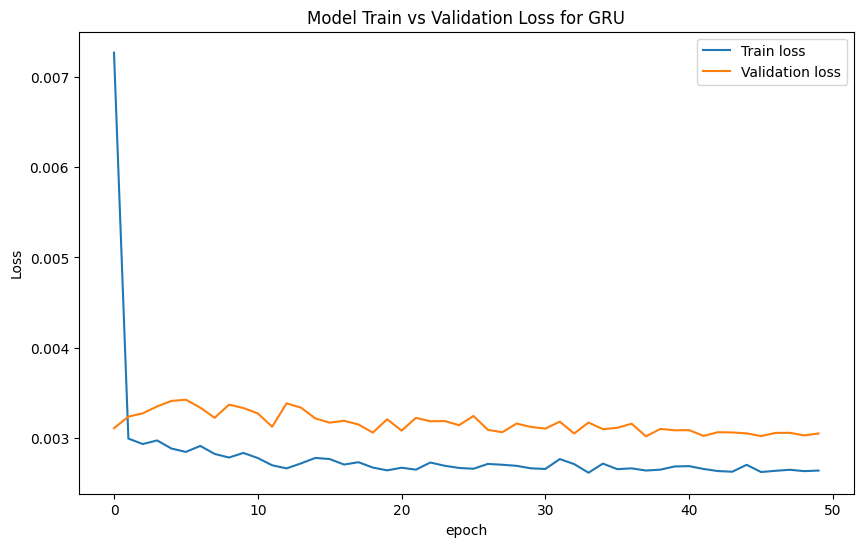

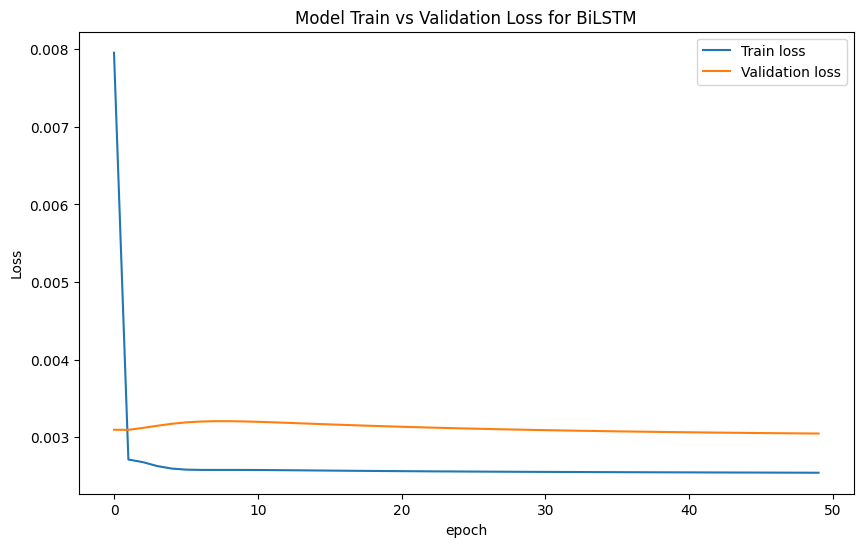

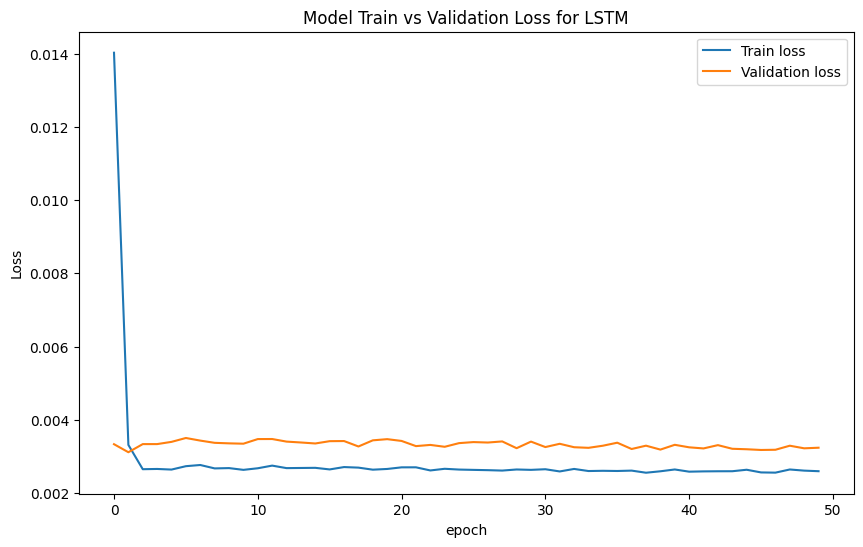

In [37]:
# Evaluating The Model
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
 
plot_loss (history_gru, 'GRU')
plot_loss (history_bilstm, 'BiLSTM')
plot_loss (history_lstm, 'LSTM')

In [38]:
# We will concatenate the dataset and then scale them, as the last 1 data needs to be from training set
dataset_total = df['water_discharge']
inputs = dataset_total[len(dataset_total) - len(testing_set) - 1:].values
inputs = inputs.reshape(-1,1) # reshape(-1,1) means one column with all rows
inputs = sc.transform(inputs)

X_test = []
for i in range(1, test_size+1): # 1+5276(test size)
    X_test.append(inputs[i-1:i, 0])

X_test = np.array(X_test)
# 3D format for LSTM
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [39]:
inputs.shape

(945, 1)

In [40]:
X_test.shape

(944, 1, 1)

In [41]:
#preict the model
# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    prediction = sc.inverse_transform(prediction)
    return prediction
prediction_gru = prediction(model_gru)
prediction_bilstm = prediction(model_bilstm)
prediction_lstm = prediction(model_lstm)

30/30 [==============================] - 1s 2ms/step


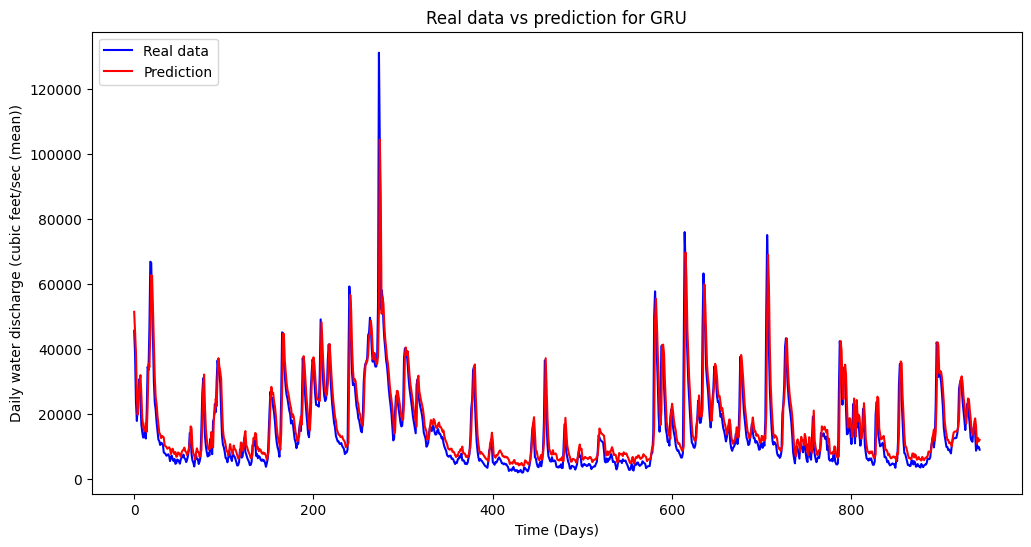

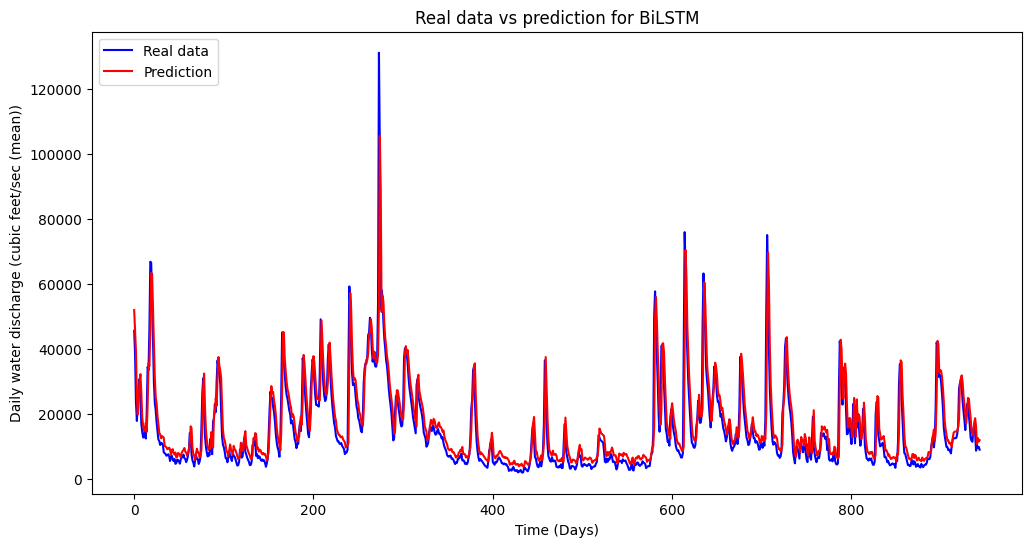

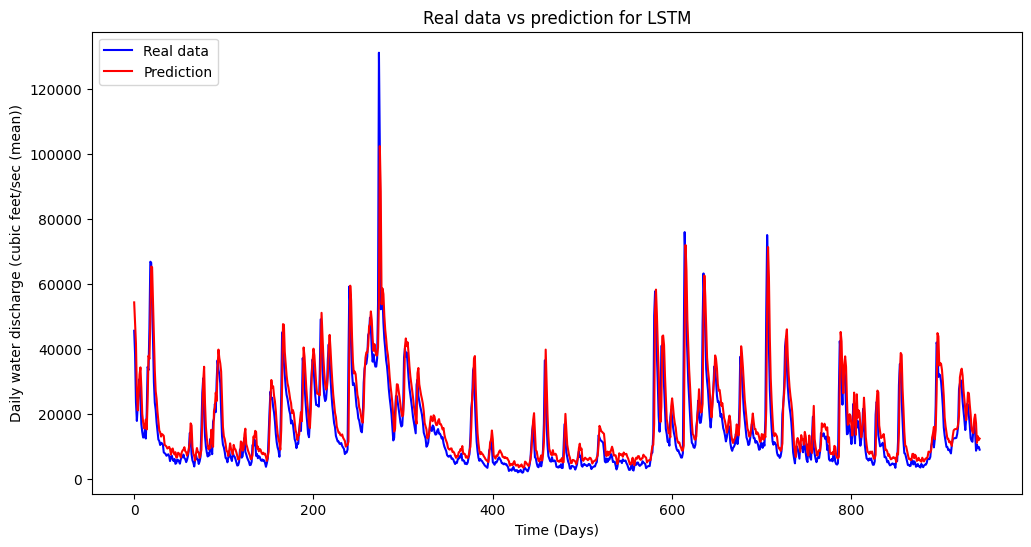

In [42]:
# Plot test data vs prediction
# Prediction is on top of real data
def plot_future(prediction, model_name, y_test):
    plt.figure(figsize=(12, 6))
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), 
             label='Real data', color='b')
    plt.plot(np.arange(range_future), 
             np.array(prediction),label='Prediction',color='r')
    
    plt.title('Real data vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (Days)')
    plt.ylabel('Daily water discharge (cubic feet/sec (mean))')
 
plot_future(prediction_gru, 'GRU', testing_set)
plot_future(prediction_bilstm, 'BiLSTM', testing_set)
plot_future(prediction_lstm, 'LSTM', testing_set)

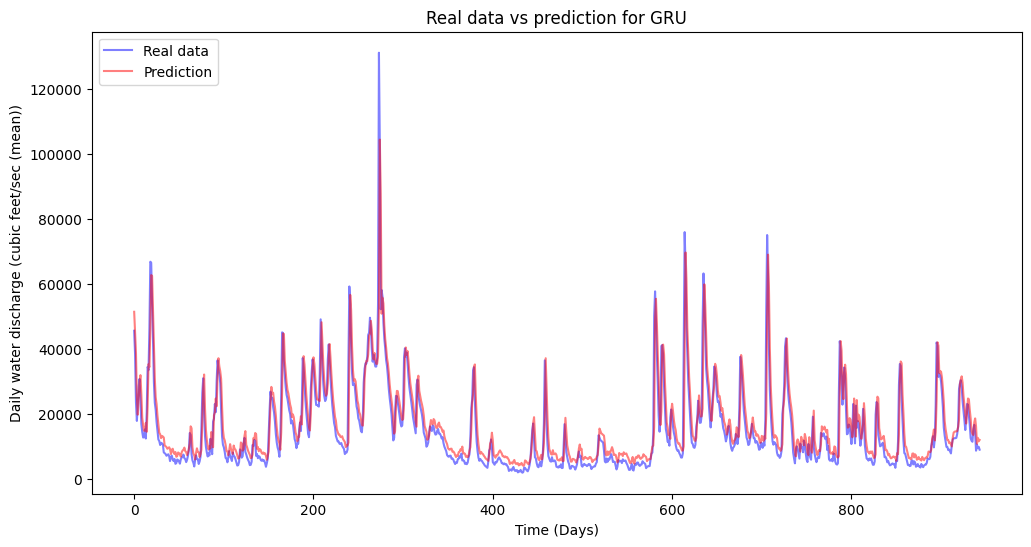

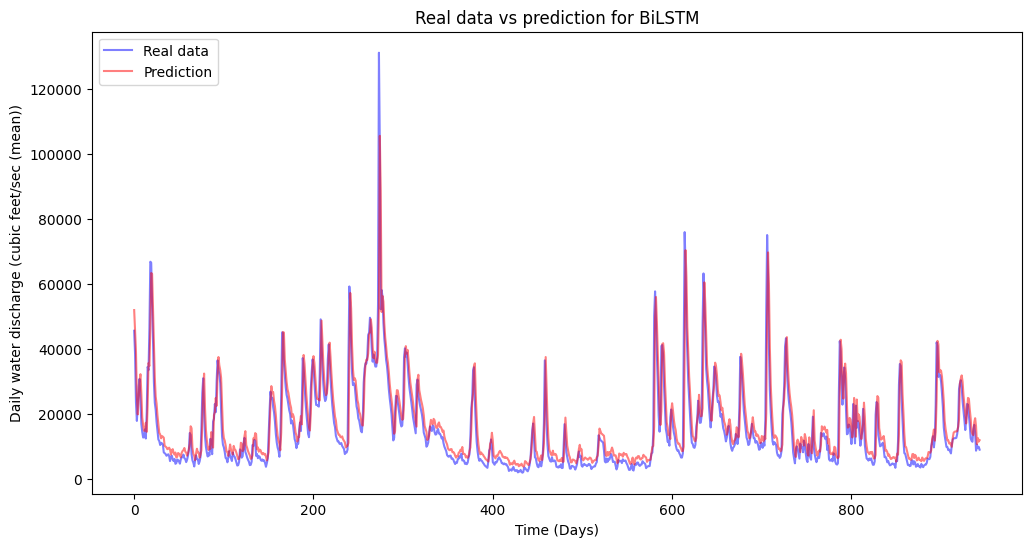

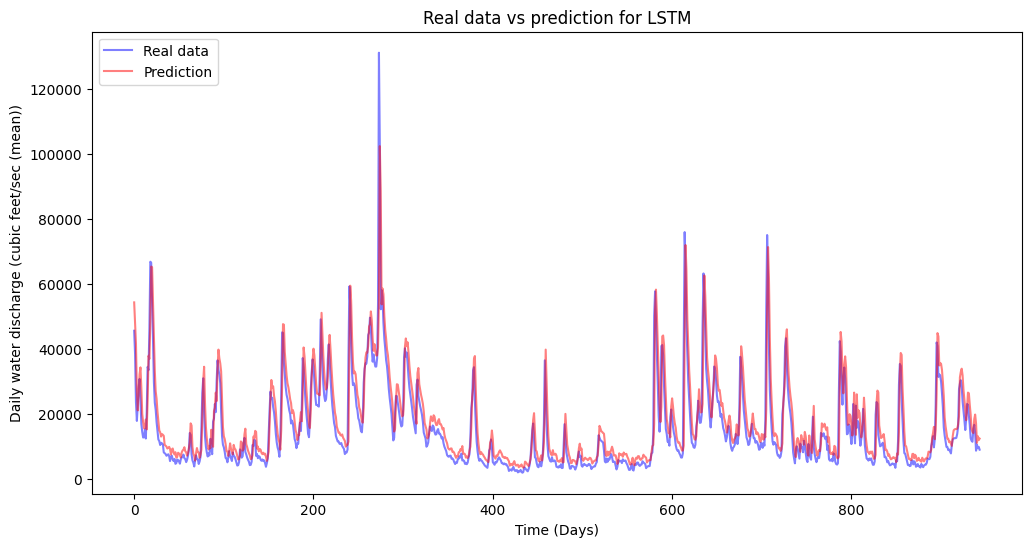

In [43]:
# Plot test data vs prediction
# Prediction is on top of real data
def plot_future(prediction, model_name, y_test):
    plt.figure(figsize=(12, 6))
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), 
             label='Real data', color='b',alpha=0.5)
    plt.plot(np.arange(range_future), 
             np.array(prediction),label='Prediction',color='r',alpha=0.5)
    
    plt.title('Real data vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (Days)')
    plt.ylabel('Daily water discharge (cubic feet/sec (mean))')
 
plot_future(prediction_gru, 'GRU', testing_set)
plot_future(prediction_bilstm, 'BiLSTM', testing_set)
plot_future(prediction_lstm, 'LSTM', testing_set)

In [44]:
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions-actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    mape= np.mean(np.abs(errors/actual)*100)
    
    print(model_name + ':')
    print('Mean Absolute Error (MAE): {:.4f}'.format(mae))
    print('Mean Squared Error (MSE): {:.4f}'.format(mse))
    print('Root Mean Square Error(RMSE): {:.4f}'.format(rmse))
    print('Mean Absolute Percentage Error(MAPE): {:.4f}'.format(mape))
    print('')
evaluate_prediction(prediction_gru, testing_set, 'GRU')
evaluate_prediction(prediction_bilstm, testing_set, 'Bidirectiona LSTM')
evaluate_prediction(prediction_lstm, testing_set, 'LSTM')

GRU:
Mean Absolute Error (MAE): 3925.2925
Mean Squared Error (MSE): 36195680.2620
Root Mean Square Error(RMSE): 6016.2846
Mean Absolute Percentage Error(MAPE): 33.9566

Bidirectiona LSTM:
Mean Absolute Error (MAE): 3906.8789
Mean Squared Error (MSE): 36369609.1146
Root Mean Square Error(RMSE): 6030.7221
Mean Absolute Percentage Error(MAPE): 32.7415

LSTM:
Mean Absolute Error (MAE): 4387.7265
Mean Squared Error (MSE): 40849626.6398
Root Mean Square Error(RMSE): 6391.3713
Mean Absolute Percentage Error(MAPE): 35.4819



In [45]:
from sklearn.metrics import r2_score

GRU_r2 = r2_score(testing_set, prediction_gru)
print(f'R2 score of GRU: {GRU_r2}')

BiLSTM_r2 = r2_score(testing_set, prediction_bilstm)
print(f'R2 score of BiLSTM: {BiLSTM_r2}')

LSTM_r2 = r2_score(testing_set, prediction_lstm)
print(f'R2 score of LSTM: {LSTM_r2}')

R2 score of GRU: 0.788506006671089
R2 score of BiLSTM: 0.7874897277304201
R2 score of LSTM: 0.7613126593695477
